## imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno

from utils import *

In [2]:
from sklearn.impute import KNNImputer

## preprocessing

In [3]:
def read_data_files():
    df_wf1 = pd.read_csv('data/wf1_data.csv')
    df_wf2 = pd.read_csv('data/wf2_data.csv')
    df_wf3 = pd.read_csv('data/wf3_data.csv')
    sample_submission = pd.read_csv('data/sample_submission.csv')
    return (df_wf1, df_wf2, df_wf3, sample_submission)

def merge_data():
    df_merged = df_wf1.merge(df_wf2, how='outer', on='date', suffixes=['_wf1', '_wf2'])
    df_merged = df_merged.merge(df_wf3, how='outer', on='date')
    df_merged['date'] = pd.to_datetime(df_merged.date, format='%Y%m%d%H')
    df_merged = df_merged.set_index('date')
    df_merged = df_merged.sort_index()
    df_merged.columns = pd.MultiIndex.from_product([['wf1','wf2','wf3'],['wp','ws']])
    df_merged = df_merged.resample('h').asfreq()
    return df_merged

In [4]:
(df_wf1, df_wf2, df_wf3, sample_submission) = read_data_files()
df_all = merge_data()

In [5]:
df_all

wf1          wf2          wf3      
                        wp    ws     wp    ws     wp    ws
date                                                      
2009-07-01 01:00:00  0.085  2.47  0.257  4.27  0.105  3.81
2009-07-01 02:00:00  0.020  2.40  0.178  3.65  0.033  3.68
2009-07-01 03:00:00  0.060  2.51  0.109  3.19  0.022  3.66
2009-07-01 04:00:00  0.045  2.73  0.079  2.90  0.039  3.70
2009-07-01 05:00:00  0.035  2.93  0.099  2.72    NaN   NaN
...                    ...   ...    ...   ...    ...   ...
2010-06-30 19:00:00    NaN  7.25    NaN  5.54    NaN  6.75
2010-06-30 20:00:00    NaN  7.09    NaN  5.74    NaN  6.20
2010-06-30 21:00:00    NaN  6.63    NaN  5.22    NaN  5.61
2010-06-30 22:00:00    NaN  5.74    NaN  3.94    NaN  5.10
2010-06-30 23:00:00    NaN  4.64    NaN  3.61    NaN  4.64

[8759 rows x 6 columns]

## exploration

In [6]:
df_all.describe()

wf1                       wf2                       wf3  \
                wp           ws           wp           ws           wp   
count  7271.000000  8759.000000  8735.000000  8759.000000  7970.000000   
mean      0.225795     4.010731     0.336018     4.642989     0.257337   
std       0.228963     1.823608     0.318107     2.346111     0.276067   
min       0.000000     0.020000     0.000000     0.100000     0.000000   
25%       0.040000     2.760000     0.069000     2.890000     0.017000   
50%       0.150000     3.640000     0.217000     4.220000     0.160000   
75%       0.336000     4.990000     0.563000     6.040000     0.424000   
max       0.947000    13.910000     0.978000    16.090000     0.981000   

                    
                ws  
count  7994.000000  
mean      4.338232  
std       2.112425  
min       0.090000  
25%       2.830000  
50%       3.945000  
75%       5.550000  
max      15.550000

In [7]:
def plot_missing(df):
    # plot
    fig, ax = plt.subplots(1, 1, figsize=[20, 12])
    msno.matrix(df=df, ax=ax, color=(0.2, 0.2, 0.2), sparkline=False, fontsize=20)
    
    # ylabels
    months = pd.Series([str(i.month)+'/'+str(i.year) for i in df.index]).unique()
    ylim_start, ylim_end = ax.get_ylim()
    step_size = df.shape[0] / len(months)
    _ = ax.yaxis.set_ticks(np.arange(ylim_end, ylim_start, step_size))
    _ = ax.yaxis.set_ticklabels(months, fontsize=20)

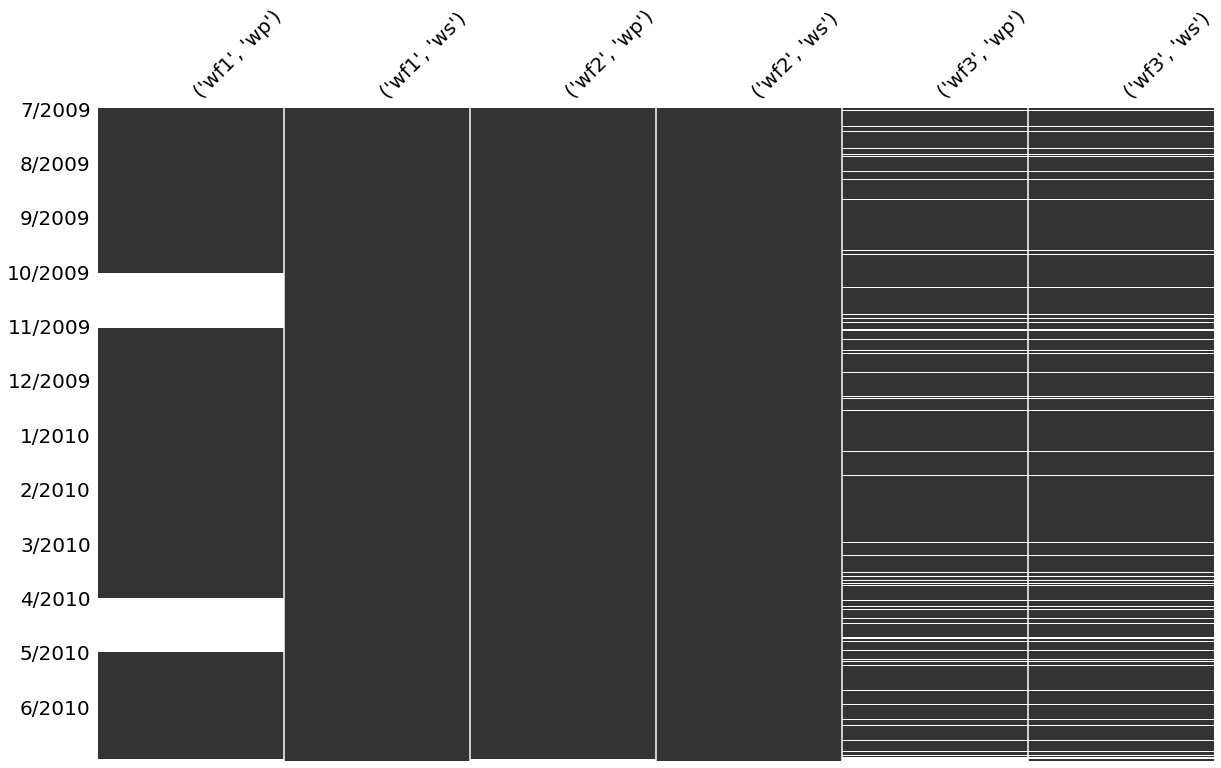

In [8]:
plot_missing(df_all)

In [9]:
def plot_zeros(df):
    df = df.copy()
    df = df.fillna(-1)\
           .replace(0, np.nan)
    plot_missing(df)

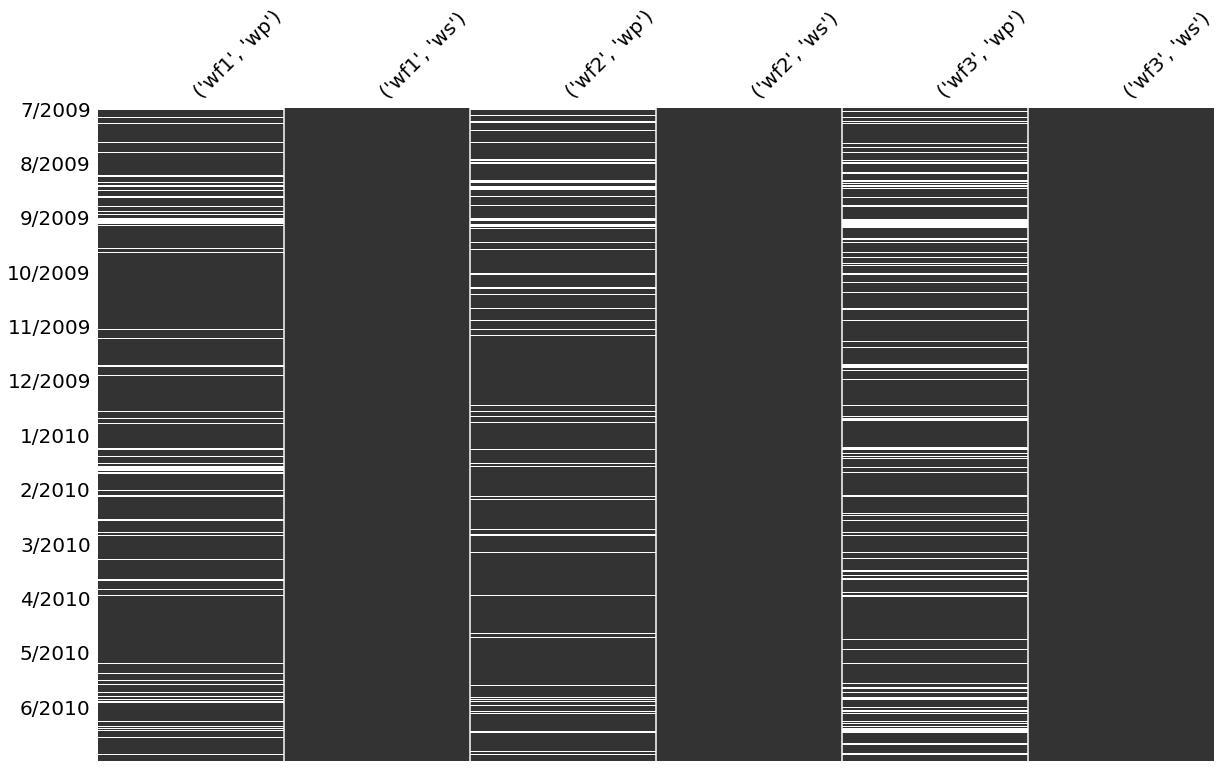

In [10]:
plot_zeros(df_all)

<AxesSubplot:>

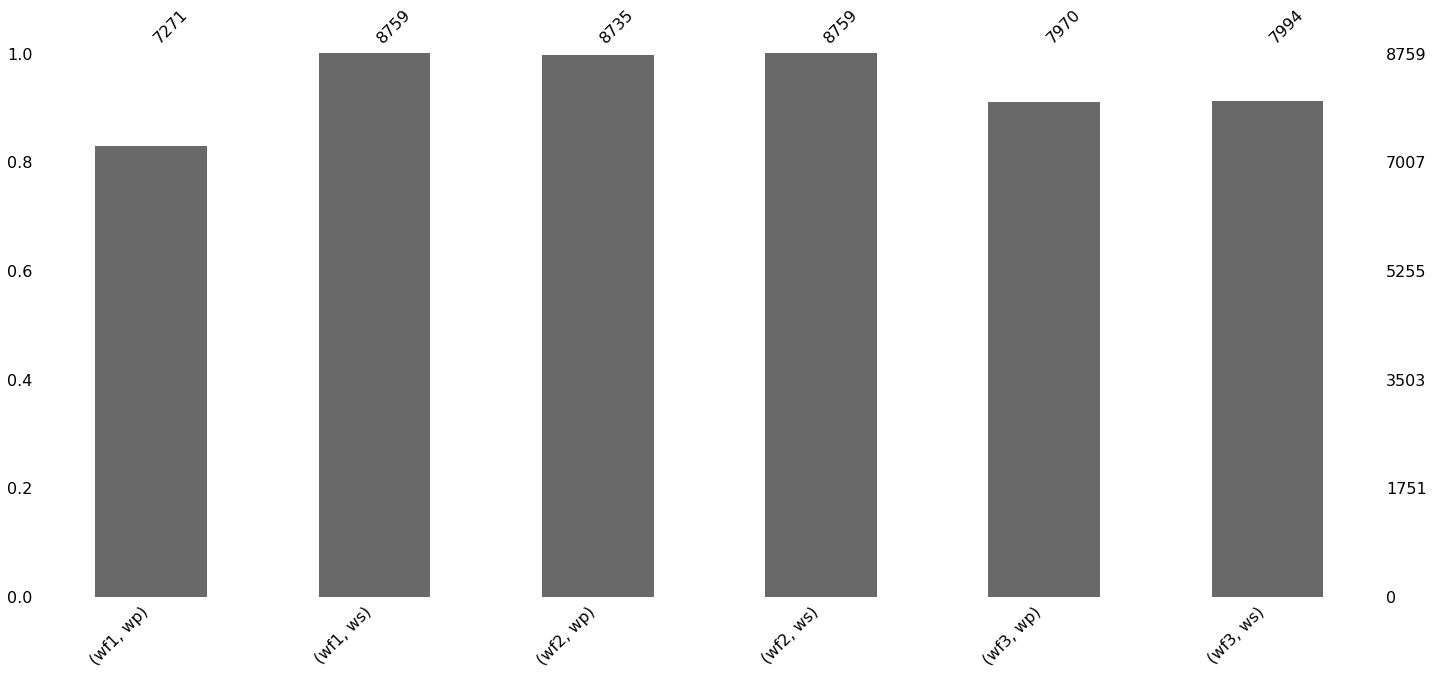

In [11]:
msno.bar(df_all)

## fill missing & split

In [12]:
def fill_gaps(df, knn=False):
    data=df.copy()
    if knn:
        imputer = KNNImputer()
        data_imputed = imputer.fit_transform(data) # This may take a bit to run
        imputed = pd.DataFrame(data_imputed, index=data.index, columns=data.columns)
    else:
        imputed = data.interpolate()
    return imputed

def split_train_test(df, test_length=24):
    train = df[:-test_length]
    test = df[-test_length:]
    return (train, test)

In [13]:
df_imputed = fill_gaps(df_all, knn=True)
df_train, df_test = split_train_test(df_imputed)

In [14]:
df_train

wf1          wf2           wf3       
                        wp    ws     wp    ws      wp     ws
date                                                        
2009-07-01 01:00:00  0.085  2.47  0.257  4.27  0.1050  3.810
2009-07-01 02:00:00  0.020  2.40  0.178  3.65  0.0330  3.680
2009-07-01 03:00:00  0.060  2.51  0.109  3.19  0.0220  3.660
2009-07-01 04:00:00  0.045  2.73  0.079  2.90  0.0390  3.700
2009-07-01 05:00:00  0.035  2.93  0.099  2.72  0.1048  2.910
...                    ...   ...    ...   ...     ...    ...
2010-06-29 19:00:00  0.737  9.38  0.316  6.51  0.4680  9.970
2010-06-29 20:00:00  0.802  9.38  0.257  6.19  0.6610  9.860
2010-06-29 21:00:00  0.827  9.11  0.208  6.04  0.4850  9.480
2010-06-29 22:00:00  0.837  8.55  0.148  6.04  0.5696  8.052
2010-06-29 23:00:00  0.742  7.71  0.099  5.90  0.4020  8.020

[8735 rows x 6 columns]

## stationarity

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

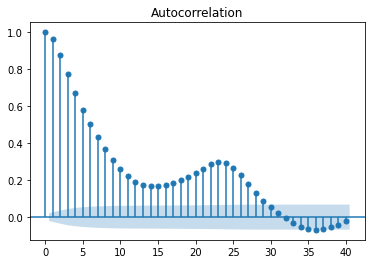

In [149]:
plot_acf(df_train['wf1','ws'])
plt.show()

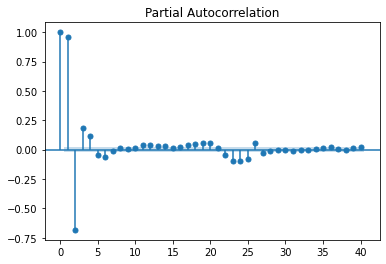

In [148]:
plot_pacf(df_train['wf1','ws'])
plt.show()

In [22]:
def plot_decomposition(series):
    decomposition = seasonal_decompose(series)
    decomposition.plot()

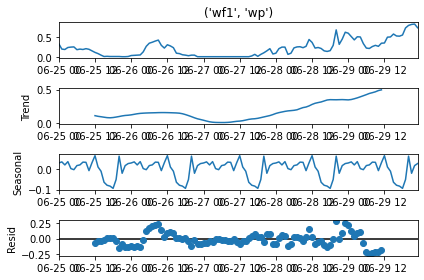

In [150]:
plot_decomposition(df_train['wf1','wp'][-24*5:])

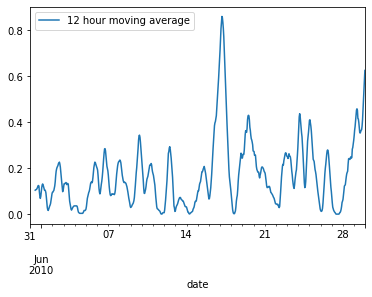

In [163]:
df_train['wf1','wp'][-24*30:].rolling(12).mean().plot(label='12 hour moving average', legend=True)
plt.show()

<AxesSubplot:xlabel='date'>

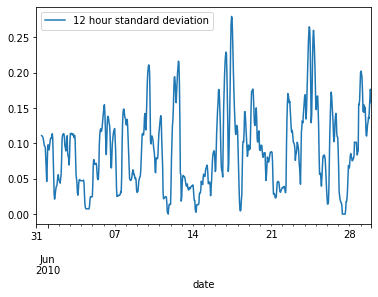

In [164]:
df_train['wf1','wp'][-24*30:].rolling(12).std().plot(label='12 hour standard deviation', legend=True)

In [185]:
adfuller(df_train['wf1','wp'])

(-12.40488073652162,
 4.475573026072832e-23,
 25,
 8709,
 {'1%': -3.4311010883544237,
  '5%': -2.8618719309555227,
  '10%': -2.5669466818853945},
 -19835.156014657634)

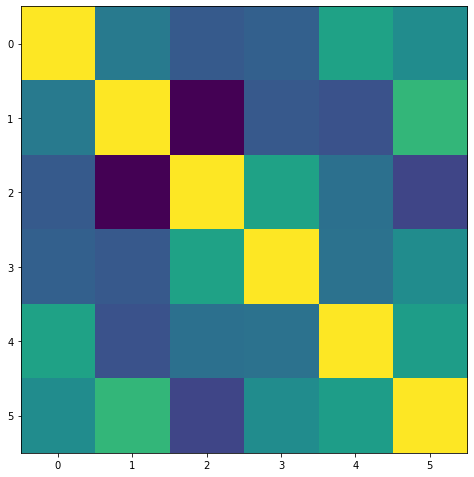

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,10))
ax.imshow(df_train.dropna().corr())
#cb = ax.

In [180]:
df_train.dropna().corr().round(2)

wf1         wf2         wf3      
          wp    ws    wp    ws    wp    ws
wf1 wp  1.00  0.66  0.59  0.60  0.76  0.71
    ws  0.66  1.00  0.43  0.59  0.57  0.81
wf2 wp  0.59  0.43  1.00  0.76  0.64  0.55
    ws  0.60  0.59  0.76  1.00  0.64  0.70
wf3 wp  0.76  0.57  0.64  0.64  1.00  0.75
    ws  0.71  0.81  0.55  0.70  0.75  1.00

In [181]:
table =pd.DataFrame(data=[0.66,0.76,0.75], index=['wf1','wf2','wf3'], columns=['wp-ws correlation'])
table

,wp-ws correlation
wf1,0.66
wf2,0.76
wf3,0.75


In [168]:
def prepare_sarimax_exog(df_train, df_test, val_length=24, plant='wf1'):
    #training
    y_train = df_train[plant].wp.to_frame()[:-val_length]
    X_train = df_train[plant].ws.to_frame()[:-val_length]
    
    #validation
    y_val = df_train[plant].wp.to_frame()[-val_length:]
    X_val = df_train[plant].ws.to_frame()[-val_length:]
    
    #test
    y_test = df_test[plant].wp.to_frame()
    X_test = df_test[plant].ws.to_frame()
    
    return (X_train, y_train, X_val, y_val, X_test, y_test)

def predict_farm_sarimax_exog(wf, train_days=60):
    #data prep
    (X_train, y_train, X_val, y_val, X_test, y_test) = prepare_sarimax_exog(df_train[-train_days*24:], df_test, val_length=24, plant=wf)
    
    #model fitting
    sarimax_exog = pm.AutoARIMA(#seasonal=True,
                               #m=24, 
                               maxiter=20,
                               method='nm',
                               trace=True,
                               suppress_warnings=True,
                               stepwise=True,
                              )
    sarimax_exog.fit(y_train, X_train)
    
    #predict
    predictions = sarimax_exog.predict(24, X_val)
    
    #score
    print(wf, mean_absolute_error(y_val, predictions))
    
    return predictions

In [172]:
predictions = np.array([])
for wf in ['wf2']:#['wf1', 'wf2', 'wf3']:
    predictions = np.concatenate([predictions, predict_farm_sarimax_exog(wf, train_days=30)])
predictions

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1048.554, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-138.747, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1044.927, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-464.097, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-82.503, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1051.205, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-872.200, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1053.529, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1050.742, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1052.940, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1057.496, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-459.613, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1049.596, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1055.635, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]  

array([0.66599423, 0.54375709, 0.49760751, 0.47259105, 0.44402266,
       0.40910141, 0.3710659 , 0.32941823, 0.29315077, 0.27728516,
       0.2920544 , 0.32669198, 0.35971808, 0.37560685, 0.37753116,
       0.37312485, 0.36809683, 0.36082762, 0.34825151, 0.3302677 ,
       0.31268038, 0.30376134, 0.30247245, 0.29453857])

Text(0.5, 1.0, 'Wind Farm 2')

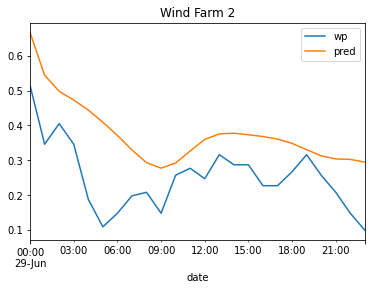

In [140]:
y_vall = df_train['wf2'].wp.to_frame()[-24:]
y_vall.plot(label="original data")
pd.Series(predictions, index=y_vall.index).plot(label="pred")
plt.legend()
plt.title('Wind Farm 2')

In [177]:
def prepare_sarimax_exog_oos(df_train, df_test, plant='wf1'):
    #training
    y_train = df_train[plant].wp.to_frame()
    X_train = df_train[plant].ws.to_frame()
    
    #test
    y_test = df_test[plant].wp.to_frame()
    X_test = df_test[plant].ws.to_frame()
    
    return (X_train, y_train, X_test, y_test)

def predict_farm_sarimax_exog_oos(wf, train_days=60):
    #data prep
    (X_train, y_train, X_test, y_test) = prepare_sarimax_exog_oos(df_train[-train_days*24:], df_test, plant=wf)
    
    #model fitting
    sarimax_exog = pm.AutoARIMA(#seasonal=True,
                               #m=24, 
                               maxiter=20,
                               method='nm',
                               trace=True,
                               suppress_warnings=True,
                               stepwise=True,
                              )
    sarimax_exog.fit(y_train, X_train)
    
    #predict
    predictions = sarimax_exog.predict(24, X_test)
    
    return predictions

In [174]:
predictions_oos = np.array([])
for wf in ['wf2']:#['wf1', 'wf2', 'wf3']:
    predictions_oos = np.concatenate([predictions_oos, predict_farm_sarimax_exog_oos(wf, train_days=60)])
predictions_oos

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2122.778, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2062.220, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2085.169, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2091.071, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2063.524, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2126.779, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2098.537, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2093.098, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2127.805, Time=0.46 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2104.864, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2132.219, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-2134.025, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-2052.571, Time=0.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1328.294, Time=0.52 sec
 ARIMA(3,1,4)(0,0,0

array([0.09674589, 0.07879175, 0.08847238, 0.09957507, 0.10754258,
       0.11334256, 0.11771908, 0.12208537, 0.12831477, 0.13629574,
       0.14562418, 0.15584971, 0.16737625, 0.17968297, 0.19125726,
       0.1999588 , 0.20348224, 0.20468497, 0.20761741, 0.21560307,
       0.22082793, 0.21150767, 0.18693535, 0.18120241])

In [125]:
def generate_submission_file(predictions):
    test = pd.DataFrame(predictions)
    test.columns = ['value']
    test.to_csv('submission.csv', index=False)
    return test

In [175]:
def generate_wf2_file(predictions):
    test = pd.DataFrame(predictions)
    test.columns = ['value']
    test.to_csv('predictions_wf2.csv', index=False)
    return test

In [176]:
generate_wf2_file(predictions_oos)

,value
0,0.096746
1,0.078792
2,0.088472
3,0.099575
4,0.107543
5,0.113343
6,0.117719
7,0.122085
8,0.128315
9,0.136296


In [78]:
predictions = sarimax_exog.predict(24, X_val)

In [38]:
def data_for_sarimax_exog(df_train, df_test):
    y_train = df_train.wp.to_frame()
    X_train = df_train.ws.to_frame()
    y_test = df_test.wp.to_frame()
    X_test = df_test.ws.to_frame()
    return (X_train, y_train, X_test, y_test)

In [39]:
X_train, y_train, X_test, y_test = data_for_sarimax_exog(df_train['wf2'][:-24], df_train['wf2'][-24:])

In [40]:
sarimax_pipeline_exog = Pipeline([
    #('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
    ('arima', pm.AutoARIMA(seasonal=True,
                           m=24, 
                           maxiter=20,
                           method='nm',
                           trace=True,
                           suppress_warnings=True,
                           stepwise=True,
                          )
    )
])

sarimax_pipeline_exog.fit(y_train[-30*24:], X_train[-30*24:])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=-1095.119, Time=2.26 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-153.462, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-1093.073, Time=1.59 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-340.123, Time=1.61 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-99.536, Time=0.16 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=-1099.428, Time=1.96 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=-1101.888, Time=0.25 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=-1099.434, Time=1.75 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=-1105.110, Time=0.25 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=-1102.210, Time=1.55 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=-1102.955, Time=1.83 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=-1100.555, Time=1.93 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=-917.125, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-1106.722, Time=0.19 sec
 ARIMA(1,0

Pipeline(steps=[('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm',
                           suppress_warnings=True, trace=True))])

/home/rubelrennfix/.virtualenvs/hckt03/lib/python3.6/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


ValueError: x and y must have same first dimension, but have shapes (8711,) and (720,)

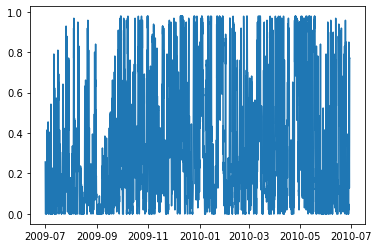

In [41]:
t=24*10
plt.plot(y_train, label='original')
plt.plot(y_train.index, sarimax_pipeline_exog.predict_in_sample(X_train), label='sarimax')
plt.legend()
plt.show()

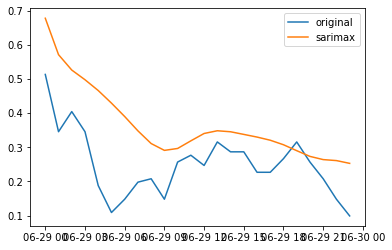

In [42]:
plt.plot(y_test, label='original')
plt.plot(y_test.index, sarimax_pipeline_exog.predict(24, X_test), label='sarimax')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import mean_absolute_error

In [82]:
print('sarimax, no exog: ', mean_absolute_error(y_test, sarimax_pipeline.predict(24)))

sarimax, no exog:  0.07104320581049277


In [83]:
print('sarimax, exog: ', mean_absolute_error(y_test, sarimax_pipeline_exog.predict(24, X_test)))

sarimax, exog:  0.3476087351765136


## modeling

In [32]:
target = df_train['wf1']['wp']
target

date
2009-07-01 01:00:00    0.085
2009-07-01 02:00:00    0.020
2009-07-01 03:00:00    0.060
2009-07-01 04:00:00    0.045
2009-07-01 05:00:00    0.035
                       ...  
2010-06-29 19:00:00    0.737
2010-06-29 20:00:00    0.802
2010-06-29 21:00:00    0.827
2010-06-29 22:00:00    0.837
2010-06-29 23:00:00    0.742
Freq: H, Name: wp, Length: 8735, dtype: float64

In [33]:
def split_train_test(df, test_length=5*24, remove=24):
    train = df[:-(test_length+remove)]
    test = df[-(test_length+remove):-remove]
    last_period = df[-remove:]
    return (train, test, last_period)

In [34]:
y_train, y_test, y_drop = split_train_test(target)

## sarimax

In [35]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm

In [36]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           method='nm', # More data means longer let's use 'nm' to make it faster
                           maxiter=20, # Let's also reduce maxiter to make it faster.
                          )
    )
])

In [37]:
%%time
sarimax_pipeline.fit(y_train[-30*24:])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=-3294.642, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=-3265.735, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=-3284.733, Time=1.49 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=-3288.990, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-3267.664, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=-3296.472, Time=2.08 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=-3298.319, Time=0.37 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=-3296.642, Time=2.73 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=-3309.796, Time=0.28 sec
 ARIMA(1,1,2)(1,0,0)[24] intercept   : AIC=-3306.265, Time=1.92 sec
 ARIMA(1,1,2)(0,0,1)[24] intercept   : AIC=-3307.601, Time=2.00 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=-3303.243, Time=2.47 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=-3290.543, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[24] intercept   : AIC=-3289.179, Time=0.28 sec
 ARIM

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
                ('arima',
                 AutoARIMA(m=24, maxiter=20, method='nm',
                           suppress_warnings=True, trace=True))])

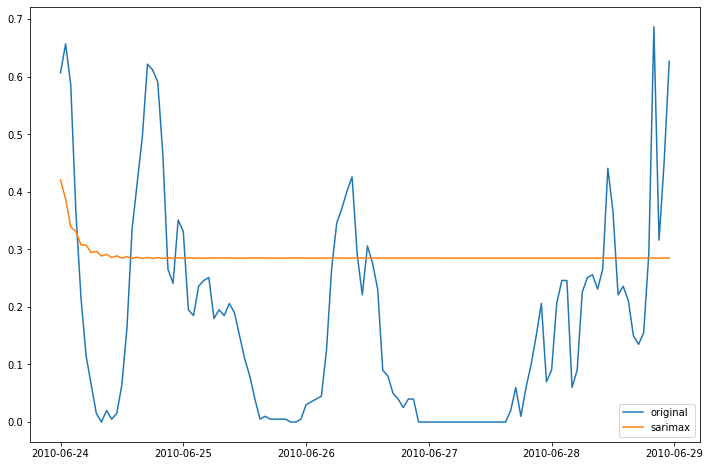

In [26]:
fig = plt.figure(figsize=(12,8))
plt.plot(y_test, label='original')
plt.plot(y_test.index, sarimax_pipeline.predict(len(y_test)), label='sarimax')
plt.legend()
plt.show()

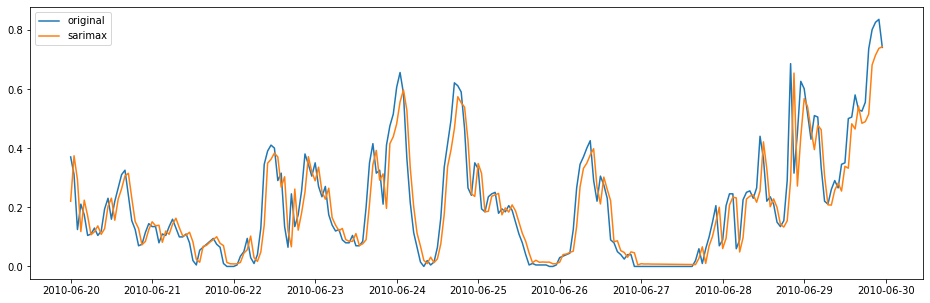

In [163]:
t=24*10
plt.plot(df_train['wf1','wp'][-t:], label='original')
plt.plot(df_train['wf1','wp'].index[-t:], sarimax_pipeline.predict_in_sample()[-t:], label='sarimax')
plt.legend()
plt.show()

<AxesSubplot:>

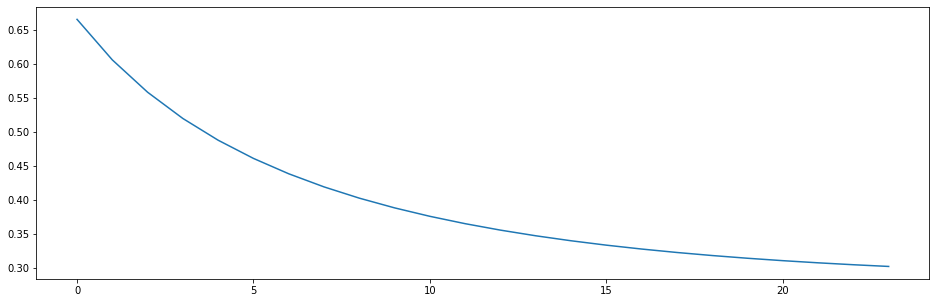

In [165]:
pd.Series(sarimax_pipeline.predict(24)).plot()
plt.show()

In [33]:
df_train['wf1']['wp']

,wp,ws
date,,
2009-07-01 01:00:00,0.085,2.47
2009-07-01 02:00:00,0.020,2.40
2009-07-01 03:00:00,0.060,2.51
2009-07-01 04:00:00,0.045,2.73
2009-07-01 05:00:00,0.035,2.93
...,...,...
2010-06-29 19:00:00,0.737,9.38
2010-06-29 20:00:00,0.802,9.38
2010-06-29 21:00:00,0.827,9.11
